In [1]:
import pandas as pd
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community

seed_value = 230293944

In [2]:
colnames=['Source', 'Target', 'Rating', 'Time'] 
df = pd.read_csv('C:/Users/DELL/Downloads/soc-sign-bitcoinalpha.csv',names = colnames, header=None)

G = nx.from_pandas_edgelist(df, source='Source', target='Target')


### a) (5 marks) Find the best division in communities of your network using both Louvain and the Greedy algorithm. Decide which one is better, explain why and relate the result to the nature of the network.


In [3]:
from community import best_partition

seed_value = 230293944

# Louvain algorithm
louvain_partition = best_partition(G, random_state=seed_value)

# Dictionary to store communities
communities = {community_id: [] for community_id in set(louvain_partition.values())}

for node, community_id in louvain_partition.items():
    communities[community_id].append(node)

print(f"Total Number of Communities: {len(communities)}")


Total Number of Communities: 19


In [4]:
from networkx.algorithms.community import greedy_modularity_communities

# Greedy algorithm
greedy_communities = list(greedy_modularity_communities(G))

greedy_partition = {node: cid for cid, nodes in enumerate(greedy_communities) for node in nodes}
total_communities_greedy = len(greedy_communities)
print(f"Total number of communities (Greedy): {total_communities_greedy}")

Total number of communities (Greedy): 42


In [5]:
# Calculating Modularity for both algorithms for comparision 
modularity_louvain = community.modularity(louvain_partition, G)
print(f"Modularity (Louvain): {modularity_louvain}")

modularity_greedy = community.modularity(greedy_partition, G)
print(f"Modularity (Greedy): {modularity_greedy}")

Modularity (Louvain): 0.45532249870287533
Modularity (Greedy): 0.4346528875090322


Here, we can observe that that modulartiy of louvain algorithm is higher as compare to greedy algorithm. And higher the modularity, better it is distributed.
Modularity = Modularity is a concept in network theory that measures the strength of division of a network into modules (or communities). Modularity is scalar value between -1 to 1 that quantifies the quality of network divisions.
$$
Modularity = (A_{ij} − k_ik_j)/2m
$$

In above program, we can observe that louvain have more dense connection between the nodes as compare to greedy algorithms.
Therefore Louvain algorithms is better.

### b) (10 marks) Run the forest fire basic model with 𝑝 = 𝑓 = 0 on the given network according to the following instructions:• Generate one initial configuration in which each site has a probability 0.4 of having a tree. You will use this same initial configuration in all your simulations.  • Start the fire on different communities each time according to the best partition of all thatyou obtained in the previous item (remember that fires can only start on trees, not empty sites).  • Calculate the average number of burnt trees over 50 simulations for each different starting community. Based on your results, if you only had resources to prevent fire on about 1/3 of the communities,which ones should be prioritised? Explain your reasoning.


In [6]:
import random

np.random.seed(230293944)
random.seed(230293944)

G = nx.from_pandas_edgelist(df, source='Source', target='Target')

# Set the probability of having a tree
tree_probability = 0.4

# Generate the initial configuration
initial_configuration = np.random.choice([0, 1], size=len(G.nodes), p=[1 - tree_probability, tree_probability])

# Assign the initial configuration to the node attributes in the graph
for i, node in enumerate(G.nodes):
    G.nodes[node]['tree'] = initial_configuration[i]

# Use Louvain algorithm for community detection
louvain_partition = best_partition(G, random_state = 230293944)  # Use the same random seed for Louvain

# Number of simulations
num_simulations = 50

# List to store the results for each community
average_burnt_trees_per_community = []

# Run simulations for each community
for community_id in set(louvain_partition.values()):
    community_nodes = [node for node, comm_id in louvain_partition.items() if comm_id == community_id and G.nodes[node]['tree'] == 1]
    total_burnt_trees = 0

    # Run simulations for each community multiple times
    for _ in range(num_simulations):
        # Reset the graph to the initial configuration
        G_copy = G.copy()
        for node in G_copy.nodes:
            G_copy.nodes[node]['burning'] = 0

        # Start the fire in the current community on a random tree
        if community_nodes:
            start_node = random.choice(community_nodes)
            G_copy.nodes[start_node]['burning'] = 1

            # Forest fire model logic
            while any(G_copy.nodes[node]['burning'] == 1 for node in G_copy.nodes):
                for node in G_copy.nodes:
                    if G_copy.nodes[node]['burning'] == 1:
                        neighbors = list(G_copy.neighbors(node))
                        for neighbor in neighbors:
                            if G_copy.nodes[neighbor]['tree'] == 1 and G_copy.nodes[neighbor]['burning'] == 0:
                                G_copy.nodes[neighbor]['burning'] = 1
                        G_copy.nodes[node]['burning'] = 2

        # Calculate the number of burnt trees after the simulation
        burnt_trees = sum(1 for node_data in G_copy.nodes(data=True) if node_data[1]['burning'] == 2)
        total_burnt_trees += burnt_trees

    # Calculating the average number of burnt trees for the current community
    average_burnt_trees = total_burnt_trees / (50*19)  # As we have 19 communities and 50 simulation
    average_burnt_trees_per_community.append(average_burnt_trees)

# Print or use the average_burnt_trees_per_community as needed
for community_id, avg_burnt_trees in enumerate(average_burnt_trees_per_community):
    print(f"Community {community_id}, Average Burnt Trees: {avg_burnt_trees}")


Community 0, Average Burnt Trees: 17.469473684210527
Community 1, Average Burnt Trees: 32.83052631578948
Community 2, Average Burnt Trees: 0.0
Community 3, Average Burnt Trees: 41.02105263157895
Community 4, Average Burnt Trees: 34.87789473684211
Community 5, Average Burnt Trees: 33.85263157894737
Community 6, Average Burnt Trees: 37.949473684210524
Community 7, Average Burnt Trees: 34.88
Community 8, Average Burnt Trees: 50.23894736842105
Community 9, Average Burnt Trees: 37.94842105263158
Community 10, Average Burnt Trees: 51.26315789473684
Community 11, Average Burnt Trees: 21.57578947368421
Community 12, Average Burnt Trees: 0.0
Community 13, Average Burnt Trees: 28.73578947368421
Community 14, Average Burnt Trees: 51.26315789473684
Community 15, Average Burnt Trees: 0.05263157894736842
Community 16, Average Burnt Trees: 0.05263157894736842
Community 17, Average Burnt Trees: 0.0
Community 18, Average Burnt Trees: 0.05263157894736842


In [7]:
num_communities_to_prevent = len(louvain_partition) // 3
prevented_communities = sorted(enumerate(average_burnt_trees_per_community), key=lambda x: x[1], reverse=True)[:num_communities_to_prevent]

print(f'\nCommunities to prioritize for fire prevention (highest average burnt trees):')
for i, (community_id, avg_burnt_trees) in enumerate(prevented_communities):
    print(f'Community {community_id}: {avg_burnt_trees} average burnt trees')



Communities to prioritize for fire prevention (highest average burnt trees):
Community 10: 51.26315789473684 average burnt trees
Community 14: 51.26315789473684 average burnt trees
Community 8: 50.23894736842105 average burnt trees
Community 3: 41.02105263157895 average burnt trees
Community 6: 37.949473684210524 average burnt trees
Community 9: 37.94842105263158 average burnt trees
Community 7: 34.88 average burnt trees
Community 4: 34.87789473684211 average burnt trees
Community 5: 33.85263157894737 average burnt trees
Community 1: 32.83052631578948 average burnt trees
Community 13: 28.73578947368421 average burnt trees
Community 11: 21.57578947368421 average burnt trees
Community 0: 17.469473684210527 average burnt trees
Community 15: 0.05263157894736842 average burnt trees
Community 16: 0.05263157894736842 average burnt trees
Community 18: 0.05263157894736842 average burnt trees
Community 2: 0.0 average burnt trees
Community 12: 0.0 average burnt trees
Community 17: 0.0 average bu

In order to save 1/3 of community, we can use 2 method which are as follow:
1. Based on highest average burnt trees -  In this approach, we will pick those communities which have highest number of burnt trees. We first sort the communities according to the average number of burnt trees and select top one third of them so we will able to save 1/3 communities but also most trees will be save as few of those communities having more than 100 trees in each.

2. Based on the density of trees in community - In this particular approach, we will save those communities who have highest density of having trees and follow same procedure of sorting based on their density and save top one third communities from there.

### C) Consider a new state of the forest fire model represented by a grey node. This state does not change. In other words, fire cannot spread to it and trees cannot grow on it. All other rules remain the same. Assuming that grey nodes are randomly distributed on the network, what is the minimum fraction of the network that they have to occupy on average at the start of the fire in order to prevent it from spreading through the whole network? Use 𝑓 an 𝑝 as in the previous item and initial configurations where each site has a probability of 0.6 of having a tree. 

In [8]:
def generate_initial_configuration(graph, tree_probability):
    size = len(graph.nodes)
    return np.random.choice([0, 1], size=size, p=[1 - tree_probability, tree_probability])

def spread_fire(graph, node, grid, grey_nodes):
    neighbors = list(graph.neighbors(node))
    for neighbor in neighbors:
        if neighbor < len(grid) and grid[neighbor] == 1 and not grey_nodes[neighbor]:
            grid[neighbor] = 2  # Mark the tree as burnt
            spread_fire(graph, neighbor, grid, grey_nodes)

def simulate_forest_fire(graph, tree_probability, grey_nodes_fraction, num_simulations):
    size = len(graph.nodes)
    total_burnt_trees = np.zeros(num_simulations)
    total_grey_nodes = np.zeros(num_simulations)

    for sim in range(num_simulations):
        # Fixed tree probability
        initial_configuration = generate_initial_configuration(graph, tree_probability)

        # Random grey nodes fraction
        grey_nodes = np.random.rand(size) < grey_nodes_fraction

        # Copy the initial configuration to the grid
        grid = np.copy(initial_configuration)

        # Start fire in a random node
        start_node = np.random.choice(list(graph.nodes))
        if start_node < len(grid) and grid[start_node] == 1:  # Ensure the starting point has a tree
            spread_fire(graph, start_node, grid, grey_nodes)

        # Count burnt trees
        burnt_trees = np.sum(grid == 2)
        total_burnt_trees[sim] = burnt_trees

        # Count grey nodes
        total_grey_nodes[sim] = np.sum(grey_nodes)

        # Count empty space
        empty_space = size - np.sum(initial_configuration) - burnt_trees
        if empty_space < 0:
            #print(f"Simulation {sim + 1} has negative empty space: {empty_space}")

            num_trees = np.sum(initial_configuration)
            num_grey_nodes = np.sum(grey_nodes)

            #print(f"Simulation {sim + 1}, Number of Trees: {num_trees}, Number of Burnt Trees: {burnt_trees}, "f"Number of Grey Nodes: {num_grey_nodes}, Number of Empty Space: {empty_space}")

    return total_burnt_trees, total_grey_nodes

seed_value = 230293944
np.random.seed(seed_value)

# Assuming 'df' is your DataFrame with 'Source' and 'Target' columns
G = nx.from_pandas_edgelist(df, source='Source', target='Target')
G_undirected = G.to_undirected()

# Ensure the graph is connected
if not nx.is_connected(G_undirected):
    #print("Graph is not connected. Making it connected...")
    components = list(nx.connected_components(G_undirected))
    largest_component = max(components, key=len)
    G_undirected = G_undirected.subgraph(largest_component).copy()

tree_probability = 0.6
num_simulations = 50

# Simulate fire with random grey nodes fraction
grey_nodes_fraction = np.random.uniform(0.0, 1.0)  # Adjust the range as needed
burnt_trees_with_grey, grey_nodes_with_grey = simulate_forest_fire(G_undirected, tree_probability, grey_nodes_fraction, num_simulations)

# Simulate fire without grey nodes for comparison
burnt_trees_without_grey, _ = simulate_forest_fire(G_undirected, tree_probability, 0, num_simulations)

# Calculate the minimum fraction of grey nodes needed to prevent the fire from spreading through the whole network
success_rate = np.sum(burnt_trees_with_grey < burnt_trees_without_grey) / num_simulations
print(f"Minimum fraction of grey nodes: {success_rate}")

# Calculate average number of burnt trees and grey nodes in each simulation
#average_burnt_trees_per_simulation = np.mean(burnt_trees_with_grey)
#average_grey_nodes_per_simulation = np.mean(grey_nodes_with_grey)



Minimum fraction of grey nodes: 0.44


## 2. (20 Marks) Consider the Voter Model as explained in the lectures.

### a) (8 marks) Using an asynchronous update rule, present a plot of the number of steps it takes on  average for the whole network to reach consensus against the probability of linking 𝑝 for 𝐺(𝑁, 𝑝) networks with 𝑁 = 50. In the initial configuration, each voter has the same probability of having one of the two possible opinions. Analyse your result by relating the time it takes to how the probability of linking defines the connections in the network model used in this exercise.

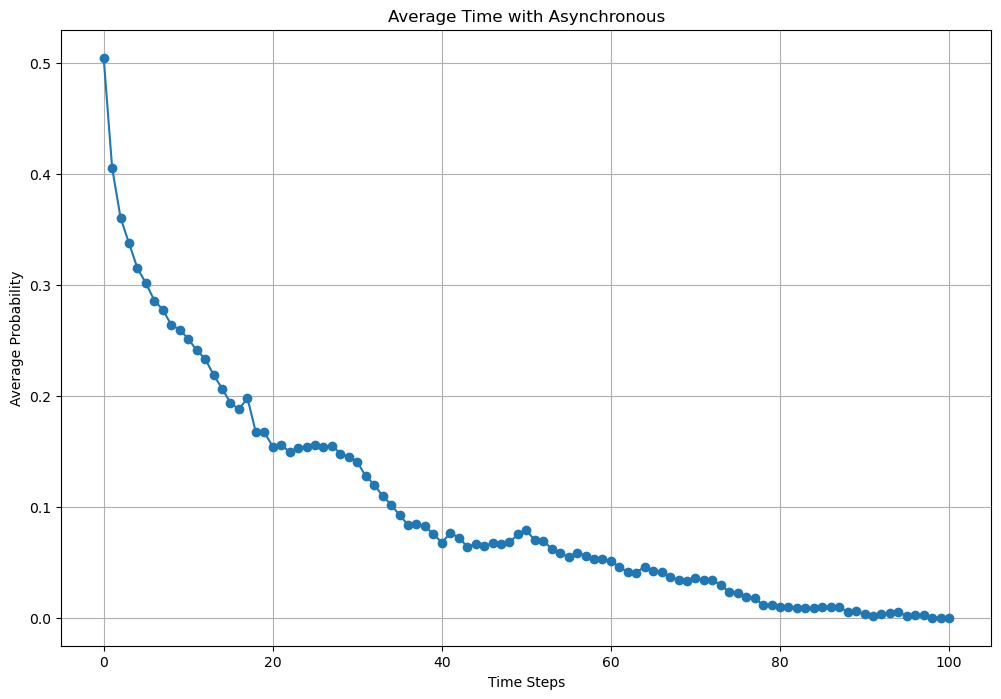

In [9]:
import random as rm
import matplotlib.pyplot as plt

def disagreement(graph, states):
    rho = 0
    for e in graph.edges():
        rho += (1 - states[e[0]] * states[e[1]]) / 2

    return rho / len(graph.edges())

def prob_flip(graph, states, node):
    n = list(graph.neighbors(node))
    nn = 0
    for v in n:
        nn += (1 - states[node] * states[v]) / 2

    return nn / len(n)

def asynchronous_update(graph, states):
    node_to_update = rm.choice(list(graph.nodes))

    if rm.random() < prob_flip(graph, states, node_to_update):
        states[node_to_update] = -states[node_to_update]

rm.seed(230293944)

N = 50
p = 0.1  
G = nx.erdos_renyi_graph(N, p)
V = G.nodes()
nodes_list = list(V)

T = 100
num_simulations = 50

# Store for each simulation
all_rho = []

for _ in range(num_simulations):
    opinions = {v: -1 if rm.random() < 0.5 else 1 for v in V}
    rho = [disagreement(G, opinions)]

    for t in range(T):
        for v in nodes_list:
            asynchronous_update(G, opinions)

        rho.append(disagreement(G, opinions))

    all_rho.append(rho)

# Calculate average disagreement values
avg_rho = np.mean(all_rho, axis=0)

# Plot the average results
plt.figure(figsize=(12, 8))
plt.plot(range(T + 1), avg_rho, marker='o')
plt.title(f'Average Time with Asynchronous')
plt.xlabel('Time Steps')
plt.ylabel('Average Probability')
plt.grid(True)
plt.show()


### b) (10 marks) Run the model on a single Barabasi-Albert network with 𝑁 = 200 nodes with synchronous update and initial configuration with every site having the same probability of having one of the two possible opinions. You do not need to average over many generated networks. Find out what is more efficient to prevent or slow down consensus: random removal of links or simultaneous targeted removal of links based on their betweenness. Try to explain the observed  differences in the results by relating them to the differences between the two processes.


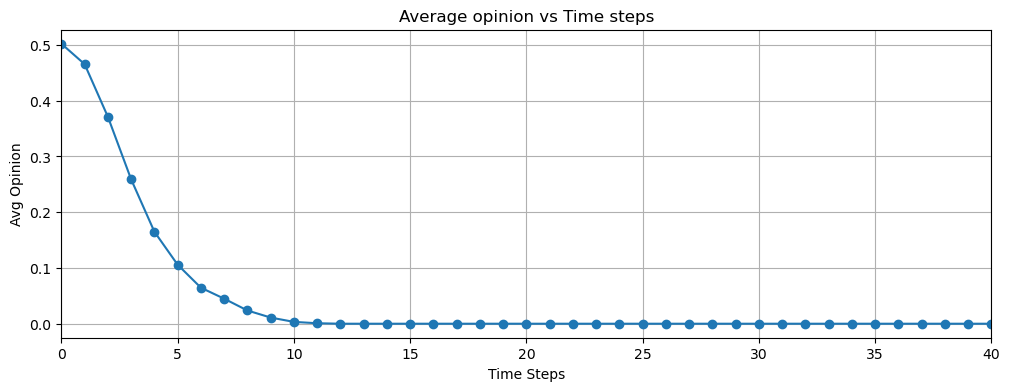

In [10]:
np.random.seed(230293944)

def initialize_opinions(G):
    # Initialize opinions randomly for nodes
    return {node: -1 if np.random.rand() < 0.5 else 1 for node in G.nodes()}

def synchronous_update(G, opinions):
    new_opinions = opinions.copy()
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        # Update opinion based on the majority opinion
        sum_opinions = sum(opinions[neighbor] for neighbor in neighbors)
        new_opinions[node] = 1 if sum_opinions >= 0 else -1

    return new_opinions

def disagreement(graph, states):
    rho = 0
    for edge in graph.edges():
        rho += (1 - states[edge[0]] * states[edge[1]]) / 2
    return rho / len(graph.edges())

N = 200
m = 2  # Barabasi-Albert parameter


G = nx.barabasi_albert_graph(N, m)# Generate Barabasi-Albert network


num_simulations = 50 # Number of simulations

T = 40
avg_disagreement_values = np.zeros(T + 1)

# Perform 50 simulations
for sim in range(num_simulations):
    # Initialize opinions for each simulation
    opinions = initialize_opinions(G)

    disagreement_values = [disagreement(G, opinions)]

    # Simulate synchronous updates
    for t in range(T):
        opinions = synchronous_update(G, opinions)
        disagreement_values.append(disagreement(G, opinions))

    # Aggregate results
    avg_disagreement_values += np.array(disagreement_values)

# Calculate average disagreement values
avg_disagreement_values /= num_simulations


# Plot average disagreement over time
plt.figure(figsize=(12, 4))
plt.plot(range(T + 1), avg_disagreement_values, marker='o')
plt.title('Average opinion vs Time steps')
plt.xlabel('Time Steps')
plt.ylabel('Avg Opinion')
plt.grid(True)
plt.margins(x=0)
plt.show()


In [11]:
np.random.seed(230293944)

def random_link_removal(G, p):
    edges_to_remove = np.random.choice(range(G.number_of_edges()), int(p * G.number_of_edges()), replace=False)
    edges_to_remove = [list(G.edges())[edge] for edge in edges_to_remove]
    
    G_removed = G.copy()
    G_removed.remove_edges_from(edges_to_remove)
    return G_removed

# Simulate targeted link removal based on betweenness centrality
def targeted_link_removal(G, k):
    betweenness = nx.edge_betweenness_centrality(G)
    sorted_edges = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    edges_to_remove = [edge for edge, _ in sorted_edges[:k]]
    
    G_removed = G.copy()
    G_removed.remove_edges_from(edges_to_remove)
    return G_removed

# network metrics
def calculate_metrics(G):
    average_degree = np.mean(list(dict(G.degree()).values()))
    average_clustering = nx.average_clustering(G)
    largest_connected_component = len(max(nx.connected_components(G), key=len))
    
    return average_degree, average_clustering, largest_connected_component

# Set parameters
p_random = 0.1  # Fraction of edges to be removed randomly
k_targeted = 10  # Number of edges to be removed based on betweenness centrality
num_simulations = 50

# Lists to store metrics for each step
metrics_random = np.zeros((num_simulations, 3))
metrics_targeted = np.zeros((num_simulations, 3))

# Run simulations
for i in range(num_simulations):
    # Simulate random link removal
    G_random_removed = random_link_removal(G, p_random)
    metrics_random[i, :] = calculate_metrics(G_random_removed)
    
    # Simulate targeted link removal
    G_targeted_removed = targeted_link_removal(G, k_targeted)
    metrics_targeted[i, :] = calculate_metrics(G_targeted_removed)

# Calculate average metrics
avg_metrics_random = np.mean(metrics_random, axis=0)
avg_metrics_targeted = np.mean(metrics_targeted, axis=0)

# Print average metrics for random link removal
print("Average Metrics for Random Link Removal:")
print(f"Average Degree: {avg_metrics_random[0]}")
print(f"Average Clustering: {avg_metrics_random[1]}")
print(f"Largest Connected Component: {avg_metrics_random[2]}")

# Print average metrics for targeted link removal
print("\nAverage Metrics for Targeted Link Removal:")
print(f"Average Degree: {avg_metrics_targeted[0]}")
print(f"Average Clustering: {avg_metrics_targeted[1]}")
print(f"Largest Connected Component: {avg_metrics_targeted[2]}")


Average Metrics for Random Link Removal:
Average Degree: 3.5699999999999954
Average Clustering: 0.06514107726697967
Largest Connected Component: 198.9

Average Metrics for Targeted Link Removal:
Average Degree: 3.8600000000000048
Average Clustering: 0.06244287377707681
Largest Connected Component: 200.0


Average Degree: The network exhibits an average degree of approximately 3.57, signifying that, on average, each node maintains connections with about 3.57 other nodes. In contrast, targeted link removal results in an increased average degree of around 3.86, indicating a higher level of overall connectivity for each node.

Average Clustering: The impact of random link removal is reflected in a moderate average clustering coefficient of 0.06514, indicating the presence of local clustering within the network. Conversely, targeted link removal yields a slightly lower average clustering coefficient of 0.06244, suggesting a potential reduction in local clustering or the formation of less tightly interconnected groups of nodes.

Largest Connected Component: Both random and targeted link removal strategies maintain relatively large connected components, comprising 198.9 and 200.0 nodes, respectively. This observation underscores the robustness of both approaches in preserving a substantial cohesive subnetwork within the overarching network structure.

If we talk about in most general situations,

Random removal of links - Links are removed without any consideration of their structure or their importance in the network. And probability of removal is equal for every single node throughout the network.There may be the case when node which play as bridge between 2 parts are remove then it cause isolation for small clusters.
- This method may yield isolated nodes or clusters, yet its impact on consensus hinges on the network's redundancy.
- In networks with many available alternative paths, the impact of randomly removing links tends to be less disruptive. This is because the presence of alternative routes allows the network to compensate for the gaps created by the removal of links.


Targeted Removal of Links Based on Betweenness - Betweenness quantifies the frequency with which a node or link serves as a crucial intermediary on the shortest paths between pairs of other nodes. In the context of targeted removing nodes, this involves the simultaneous identification and elimination of links that exhibit high betweenness centrality. 
- Elimination of links with elevated betweenness centrality can exert a pronounced influence on consensus dynamics. Such links often function as pivotal bridges or bottlenecks through which information flows efficiently. Their removal introduces disruptions to the seamless communication between diverse segments of the network, potentially introducing delays to the consensus-building process.
- Targeted removal disrupts critical pathways that are essential for efficient information flow.

In conclusion, the more effective way to prevent or slowdown the consensus is by implementing simultaneous target removal of links based on their betweenness. Targeted removal, characterized by its precision and focuses on structurally significant links, may outperform the nature of random removal, targeted removal proving more potent in networks where specific links play pivotal roles in shaping consensus,making it more efficient for prevent or slowdown to reach consensus.

### c) (2 marks) Ask ChatGPT (with the prompt you find most appropriate) what is the importance of the Max-flow Min-cut Theorem and analyse its answer explaining whether it agrees with what we studied in our lectures and what could be missing on it.

CHATGPT
The Max-flow Min-cut Theorem holds significant importance in network flow theory and graph theory, offering a fundamental understanding of flow optimization in various applications. Here are some key points highlighting its importance:

Network Flow Optimization: The Max-flow Min-cut Theorem is a cornerstone in network flow optimization problems.
It provides a theoretical foundation for finding the maximum flow in a network, which represents the maximum amount of goods, information, or resources that can be transferred through the network.

Algorithmic Applications: The Max-flow Min-cut Theorem has inspired the development of efficient algorithms to find the maximum flow in a network, such as the Ford-Fulkerson algorithm.These algorithms have wide-ranging applications in solving real-world optimization problems, including transportation networks, communication networks, and resource allocation.

    Transportation Networks: In transportation networks, the theorem helps optimize the flow of goods or vehicles from source to destination. It aids in determining the most efficient way to transport resources, considering capacity constraints in different segments of the network.

    Communication Networks: In communication networks, the theorem is relevant for optimizing data transmission, ensuring efficient routing of information.
    It assists in designing communication networks with minimal congestion and maximum data transfer capacity.

    Resource Allocation: The Max-flow Min-cut Theorem is applicable to resource allocation problems where resources need to be distributed optimally. It helps in determining the critical points (minimum cut) that, if disrupted, would limit the overall flow of resources through the network.

Computer Networks: The theorem finds applications in computer networks, guiding the design and optimization of data flow.
It contributes to ensuring reliable and efficient data transmission in computer systems.

In summary, the Max-flow Min-cut Theorem is of paramount importance in the field of network flow optimization, providing both theoretical insights and practical algorithms with diverse applications across various domains. Its understanding is crucial for designing efficient and resilient network systems.



MAX-FLOW MIN-CUT

In every flow network with source s and target t, the value of the maximum (s, t)-flow is equal to the capacity of the
minimum (s, t)-cut.
For any (G,s,t, c) the value of the max flow f∗ is equal to the capacity of the min (S,T)-cut (over all s − t cuts in G)
$$f^∗ = max{|f|} = min_{∀(S,T)} {c(S,T)}$$

With the help of example, where we have source and sink with multiple links with capacity and nodes. Cutsize is the amount of flow travelling from source to sink. In order to find the most efficient way, it will divide its weight in the links (according to link's capacity) so at the end of sink, the cutsize remains will same size as of the begining of source.


In  order to comparision between above answer and module, ChatGPT provide elaborated theoretical answers with focus on wide range of applications of it. The above does agree with what we have learned in our module. Application for transportation networks and resource allocation provide give us the better visuals in order to understand this. In Max-flow Min-cut, our focus is on 
 - Optimization : With help of this theorem, we can optimaly determines the most efficient method in real dynamic world problem like project allocation.
 - Capacity - Identifying bottlenecks and determining the maximum amount of flow a network can support. This is essential for designing efficient systems and ensuring that resources are allocated effectively.


REFERENCE

https://jeffe.cs.illinois.edu/teaching/algorithms/book/10-maxflow.pdf